1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sy
import pandas as pd
import scipy.integrate as integrate

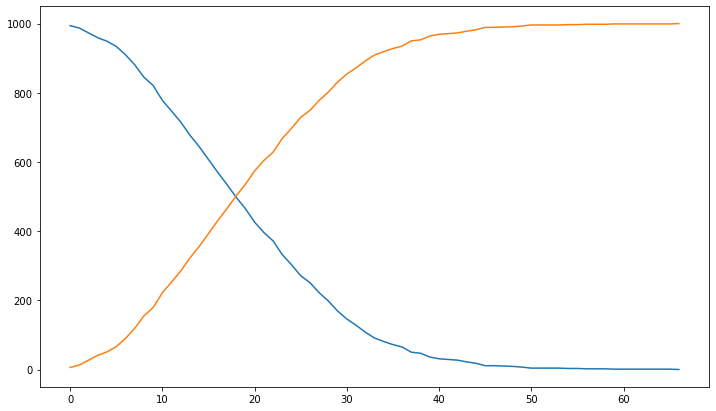

In [3]:
n = 1000
tau = 3.052*60

def p1(t):
    return (1-2**(-t/tau))

Th = n
Le = 0

Th_list = []
Le_list = []

t = 0

while (Th > 0):
    t += 1
    for i in range(Th):
        x = np.random.random()
        if x < p1(t):
            Th -= 1
            Le += 1
    Th_list.append(Th)
    Le_list.append(Le)

plt.figure(figsize=(12,7))
plt.plot(Th_list)
plt.plot(Le_list)
plt.show()

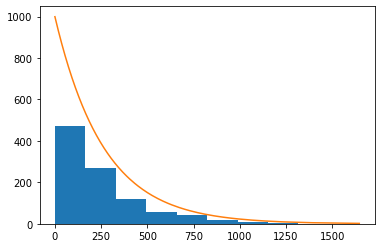

In [17]:
def p2(n):
    return (-tau)*np.log2(1-n)

rn = np.random.random(n)

plt.hist(p2(rn), bins=10)
plt.plot(np.sort(p2(rn)), (1-(np.sort(rn)))*n)
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [26]:
pi = np.pi
Z = 79
eps0 = 8.8544*(10**(-12))
E = 7.7*1.60218*(10**(-13))
a0 = 5.2918*(10**(-11))
sigma = a0/100
numpart = 1000000
e = -1.6*(10**(-19))

def beam_function(b):
    return 2*(np.arctan((Z*e**2)/(2*pi*eps0*E*b)))

def gauss_2d(sigma):
    n = int(numpart)
    z = np.random.random(n)
    theta = 2*pi*np.random.random(n)
    r_squared = -2*np.log(z)
    r = np.sqrt(r_squared)
    x = r*np.cos(theta)*sigma
    y = r*np.sin(theta)*sigma
    return (x,y)

x,y = gauss_2d(sigma)

coord = np.array(list(zip(x,y)))

b = np.array(np.linalg.norm(coord, axis = 1))

thetas = beam_function(b)

count_theta = np.sum(thetas>pi/2)

print('Particles that bounce back are:',count_theta)

Particles that bounce back are: 1565


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

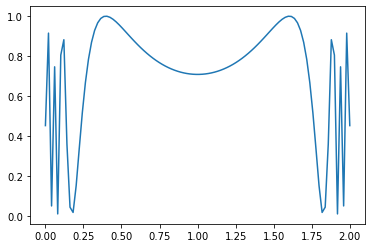

<ipython-input-64-57ebf8fc7644>:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  real_I = integrate.quad(f1,0,2)


The real integral is: 1.4516877509810684

Hit/miss method integral: 1.45364
Error with hit/miss method: -0.001952249018931651

Mean/value method integral 1.4442389602095589
Error with mean/value method: 0.007448790771509506


In [64]:
def f1(x):
    return (np.sin(1/(x*(2-x))))**2

p = np.linspace(0.001,1.999,100)
plt.plot(p,f1(p))
plt.show()

real_I = integrate.quad(f1,0,2)
print('The real integral is:',real_I[0])

# hit/miss method
N=100000
count=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y<f1(x): count+=1
I1=2*count/N
print('\nHit/miss method integral:', I1)

errHM = real_I[0]-I1 #error hit/miss
print('Error with hit/miss method:',errHM)

sum_f = 0
for i in p:
    sum_f = sum_f + f1(i)
fc = sum_f/len(p)

I2 = fc*(2-0)
print('\nMean/value method integral',I2)

errMV = real_I[0]-I2 #error mean/value
print('Error with mean/value method:', errMV)

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [20]:
def f2(x,y):
    if (x**2 + y**2) <= 1:
        return 1
    else:
        return 0
    
N=100000
count=0
for i in range(N):
    x=np.random.uniform(-1,1)
    y=np.random.uniform(-1,1)
    z=np.random.random()
    if z<f2(x,y): count+=1
A=2*count/N
print('Result of first integration:',A)

count_sphere = 0
dim=10

for count_loops in range(N):
    point = np.random.uniform(-1.0, 1.0, dim)
    distance = np.linalg.norm(point)
    if distance < 1.0:
        count_sphere += 1

ten_d_sphere = np.power(2.0, dim) * (count_sphere / N)

print('\nIntegration of 10D sphere is:',ten_d_sphere)

Result of first integration: 1.57458

Integration of 10D sphere is: 2.42688


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

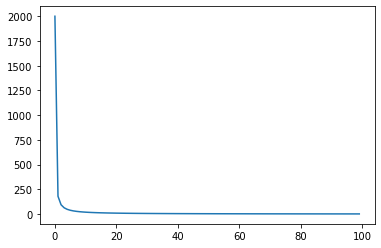

0.8325583648070328


In [96]:
def f(x):
    return (x**(-1/2))/(np.exp(x)+1)

def w(x):
    return 1/(x**1/2)

def g(x):
    return 1/(np.exp(x)+1)

h = np.linspace(0.001,1,100)

#plt.plot(f(h))
plt.plot(w(h))
#plt.plot(g(h))
plt.show()

N=100000
count=0
s = [f(j)/w(j) for j in h]
s = sum(s)/100
for i in range(N):
    x=np.random.random()
    y=100*np.random.random()
    if y<w(x): count+=1
I=count/N
I = I/s
print(I)